# Mission 2 : Réaliser une classification supervisée d'images

Nous allons maintenant aborder la classification supervisée d’images, en nous appuyant sur les enseignements de la première phase et en intégrant les outils avancés du deep learning pour répondre au besoin métier de Place du Marché.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
from sklearn import preprocessing


import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib.image import imread

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Etape 1 : Classification supervisée d'images via CNN Transfer Learning

# 1. Préparation du dataset

In [2]:
# Chargement du CSV
data = pd.read_csv("data_text_clean.csv")

# Création du chemin absolu vers chaque image
data['image_path'] = data['image'].apply(lambda x: f"/Users/jadesuchaud/Documents/images/{x}")

# Suppression des images manquantes
data = data[data['image_path'].apply(os.path.exists)].reset_index(drop=True)

# On ne garde que les colonnes utiles
data = data[['image_path', 'main_category']]
data = data.rename(columns={'main_category': 'label_name'})

# Liste des labels uniques
list_labels = sorted(data['label_name'].unique())

# Encodage des labels
le = preprocessing.LabelEncoder()
le.fit(data["label_name"])
data["label"] = le.transform(data["label_name"])

# Split train/test (80/20 stratifié)
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(
    data,
    test_size=0.2,
    stratify=data['label_name'],
    random_state=42
)
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

print(data_train.head())
print(data_test.head())

                                          image_path        label_name  label
0  /Users/jadesuchaud/Documents/images/5188dd28a6...   Home Furnishing      4
1  /Users/jadesuchaud/Documents/images/a43fbae655...         Computers      2
2  /Users/jadesuchaud/Documents/images/6b043b37c3...  Kitchen & Dining      5
3  /Users/jadesuchaud/Documents/images/7fd12776e6...         Computers      2
4  /Users/jadesuchaud/Documents/images/d06bb04b09...         Baby Care      0
                                          image_path  \
0  /Users/jadesuchaud/Documents/images/3dfd14b667...   
1  /Users/jadesuchaud/Documents/images/17a73d7c4b...   
2  /Users/jadesuchaud/Documents/images/597a9549a3...   
3  /Users/jadesuchaud/Documents/images/24e85c5904...   
4  /Users/jadesuchaud/Documents/images/59d964c38c...   

                 label_name  label  
0                 Baby Care      0  
1  Beauty and Personal Care      1  
2           Home Furnishing      4  
3  Beauty and Personal Care      1  
4  Beauty 

Baby Care


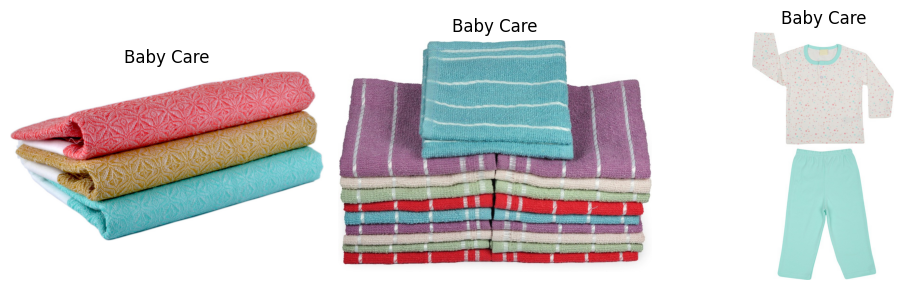

Beauty and Personal Care


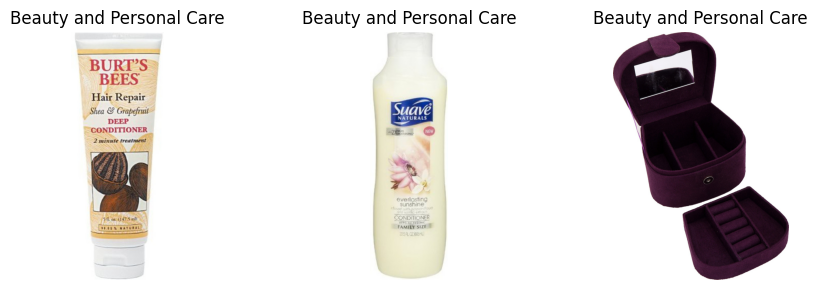

Computers


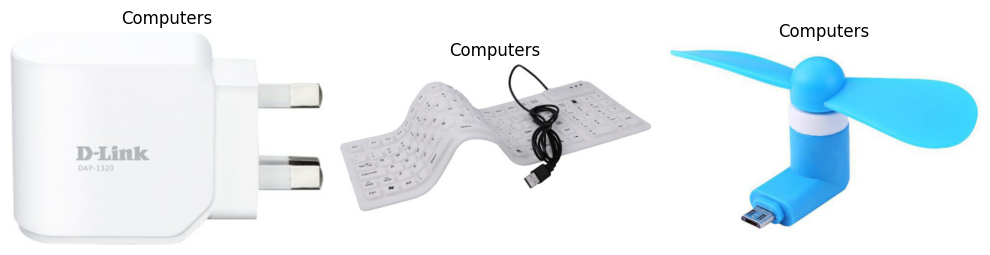

Home Decor & Festive Needs


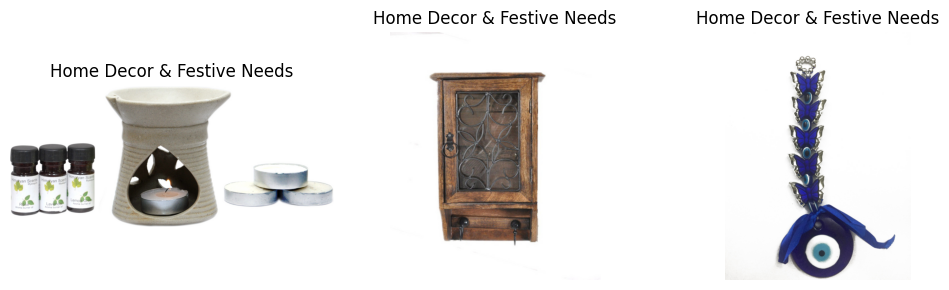

Home Furnishing


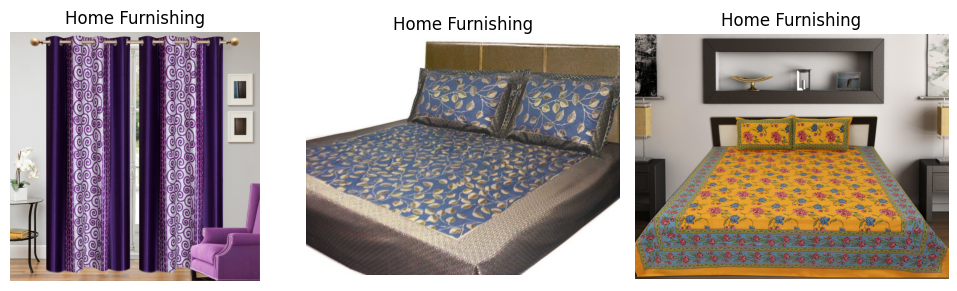

Kitchen & Dining


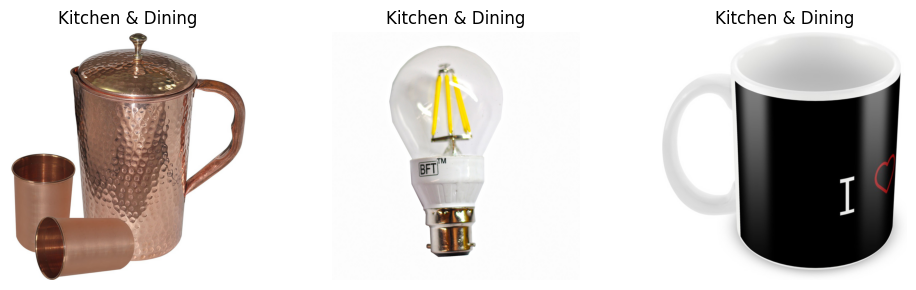

Watches


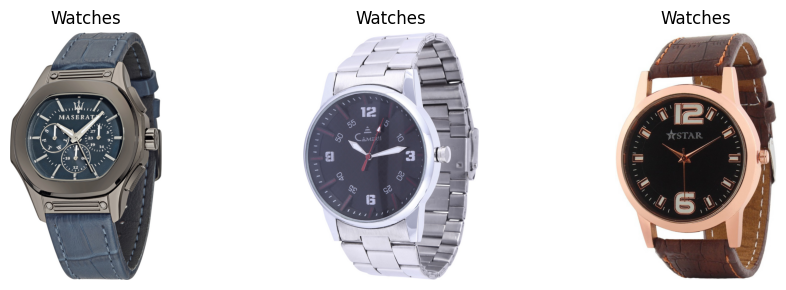

In [3]:
from matplotlib.image import imread

def list_fct(name):
    return data[data['label_name'] == name]['image_path'].tolist()

for name in list_labels:
    print(name)
    images = list_fct(name)
    plt.figure(figsize=(10, 3))
    for i in range(3):
        if i < len(images):
            plt.subplot(1, 3, i + 1)
            image = imread(images[i])
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"{name}")
    plt.tight_layout()
    plt.show()

# 2. Etude de faisabilité

## 2.1 Création du modèle pré-entraîné

In [4]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


## 2.2 Création des features des images

In [5]:
images_features = []
i=0 
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

## 2.3 Réduction dimension et analyse

### 2.3.1 Réduction de dimension PCA

In [6]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


### 2.3.2 Réduction de dimension T-SNE et affichage des images selon vraies classes

In [7]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


temps de T-SNE :             6.04 secondes


/var/folders/f1/6tjqbrdd3vz74bz9bkl_0bjh0000gn/T/ipykernel_29703/273973434.py:5: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


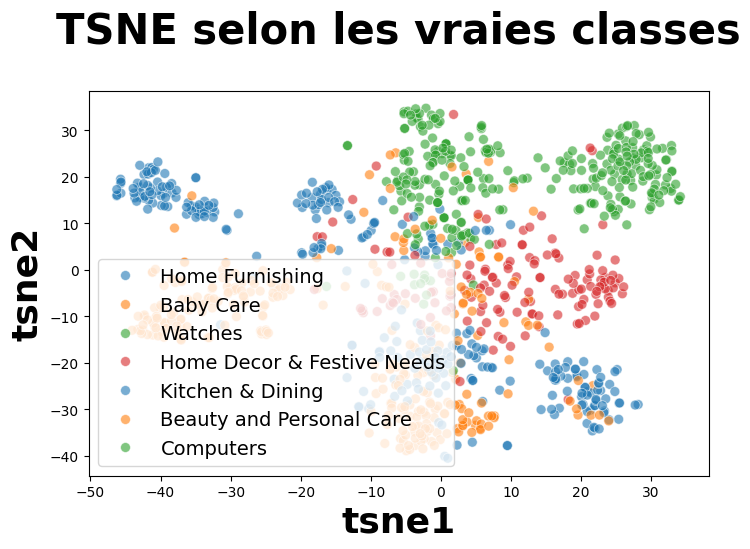

In [8]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

### 2.3.3. Création de clusters à partir du T-SNE et affichage des images selon clusters

In [9]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=4, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=4, n_init=100)

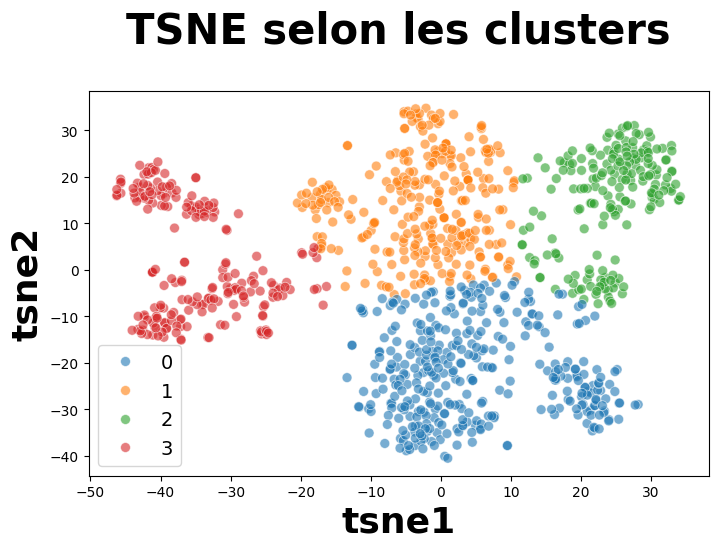

ARI :  0.37889499487890227


In [10]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### 2.3.4. Analyse par classes

In [11]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[132  12   1   5   0   0   0]
 [ 12  20   0 118   0   0   0]
 [  4 144   1   1   0   0   0]
 [ 61  35  53   1   0   0   0]
 [147   3   0   0   0   0   0]
 [  2  62   0  86   0   0   0]
 [  0  15 135   0   0   0   0]]


In [12]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [13]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [4 2 6 1 0 0 0]
[[  0   5  12   0 132   0   1]
 [  0 118  20   0  12   0   0]
 [  0   1 144   0   4   0   1]
 [  0   1  35   0  61   0  53]
 [  0   0   3   0 147   0   0]
 [  0  86  62   0   2   0   0]
 [  0   0  15   0   0   0 135]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.56      0.79      0.65       150
           2       0.49      0.96      0.65       150
           3       0.00      0.00      0.00       150
           4       0.41      0.98      0.58       150
           5       0.00      0.00      0.00       150
           6       0.71      0.90      0.79       150

    accuracy                           0.52      1050
   macro avg       0.31      0.52      0.38      1050
weighted avg       0.31      0.52      0.38      1050



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


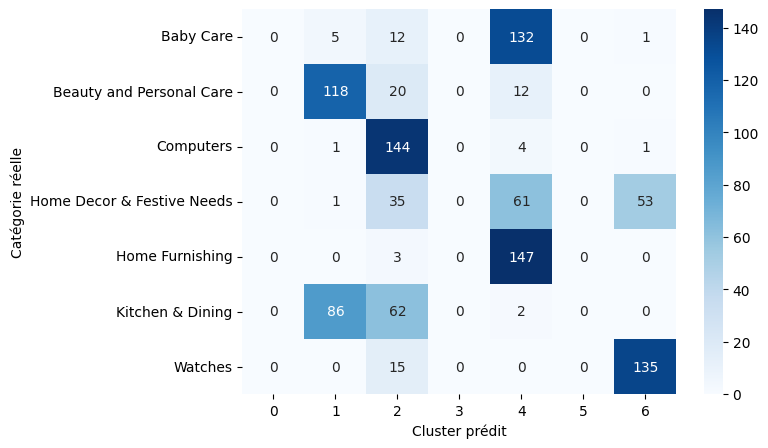

In [14]:
df_cm = pd.DataFrame(
    conf_mat,
    index=[label for label in list_labels],           # 7 lignes
    columns=[str(i) for i in range(len(list_labels))] # 7 colonnes
)
plt.figure(figsize=(7,5))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Cluster prédit")
plt.ylabel("Catégorie réelle")
plt.show()

# 3. Classification supervisée

## 3.1 Création du modèle de classification

In [15]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

## 3.2 Approche préparation initiale des images

In [16]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(data)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1050, 224, 224, 3)
(210, 224, 224, 3)


In [17]:
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(787, 224, 224, 3)

In [19]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [20]:
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                      callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3707 - loss: 6.8182
Epoch 1: val_loss improved from inf to 1.51674, saving model to ./model1_best_weights.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 101s 8s/step - accuracy: 0.3789 - loss: 6.6757 - val_accuracy: 0.7262 - val_loss: 1.5167
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6666 - loss: 2.0720
Epoch 2: val_loss improved from 1.51674 to 1.30650, saving model to ./model1_best_weights.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 99s 8s/step - accuracy: 0.6678 - loss: 2.0607 - val_accuracy: 0.7452 - val_loss: 1.3065
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7638 - loss: 1.2441
Epoch 3: val_loss improved from 1.30650 to 1.23973, saving model to ./model1_best_weights.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 99s 8s/step - accuracy: 0.7647 - loss: 1.2407 - val_accuracy: 0.7224 - val_loss: 1.2397
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8110 - loss: 0.8299
Epoch 4: val_loss improved from 1.23973 to 1.16903, saving model to ./model1_best_weights.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 98s 8s/step - accuracy: 0.8118 - loss: 0.8241 - val_accuracy: 0.7452 - val_loss: 1.1690
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8129 - loss: 0.7098
Epoch 5: val_loss improved from 1.16903 to 0.93823, saving model to ./model1_best_weights.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 105s 8s/step - accuracy: 0.8136 - loss: 0.7093 - val_accuracy: 0.7909 - val_loss: 0.9382
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8761 - loss: 0.4212
Epoch 6: val_loss did not improve from 0.93823
13/13 ━━━━━━━━━━━━━━━━━━━━ 103s 8s/step - accuracy: 0.8743 - loss: 0.4282 - val_accuracy: 0.7414 - val_loss: 1.0550
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8880 - loss: 0.4007
Epoch 7: val_loss improved from 0.93823 to 0.91044, saving model to ./model1_best_weights.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 101s 8s/step - accuracy: 0.8885 - loss: 0.3998 - val_accuracy: 0.7871 - val_loss: 0.9104
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9064 - loss: 0.2498
Epoch 8: val_loss did not improve from 0.91044
13/13 ━━━━━━━━━━━━━━━━━━━━ 100s 8s/step - accuracy: 0.9064 - loss: 0.2502 - val_accuracy: 0.7947 - val_loss: 0.9577
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9224 - loss: 0.2421
Epoch 9: val_loss improved from 0.91044 to 0.87666, saving model to ./model1_best_weights.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 101s 8s/step - accuracy: 0.9223 - loss: 0.2444 - val_accuracy: 0.8023 - val_loss: 0.8767
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9426 - loss: 0.1867
Epoch 10: val_loss did not improve from 0.87666
13/13 ━━━━━━━━━━━━━━━━━━━━ 106s 8s/step - accuracy: 0.9421 - loss: 0.1887 - val_accuracy: 0.7947 - val_loss: 0.8962
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9556 - loss: 0.1162
Epoch 11: val_loss did not improve from 0.87666
13/13 ━━━━━━━━━━━━━━━━━━━━ 101s 8s/step - accuracy: 0.9553 - loss: 0.1175 - val_accuracy: 0.8175 - val_loss: 0.9413
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9498 - loss: 0.1413
Epoch 12: val_loss did not improve from 0.87666
13/13 ━━━━━━━━━━━━━━━━━━━━ 99s 8s/step - accuracy: 0.9496 - loss: 0.1418 - val_accuracy: 0.7985 - val_loss: 0.9256
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9702 - loss: 0.0876
Epoch 13: val_loss did not improve from 0.87666
13/13 ━━━

In [21]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

25/25 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 1.0000 - loss: 0.0067
Training Accuracy: 1.0000

9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8379 - loss: 0.9980
Validation Accuracy:  0.8175


In [22]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8023
Test Accuracy       :  0.9333


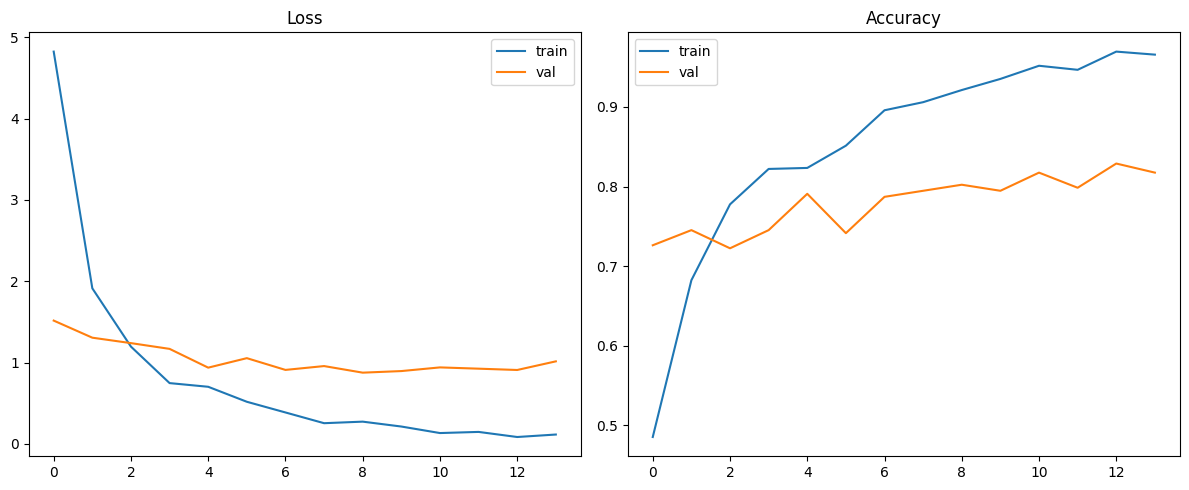

In [23]:
import matplotlib.pyplot as plt

# Affichage de l'historique d'entraînement
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    # Courbe de la loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val')
    plt.title('Loss')
    plt.legend()
    # Courbe de l'accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='val')
    plt.title('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(history1)

In [24]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step
[3 3 1 4 3 1 5 0 3 0 0 4 6 5 0 6 5 0 2 6 2 2 1 0 4 5 4 6 2 2 0 2 1 3 2 0 4
 0 0 1 6 6 1 1 4 4 0 6 2 3 1 2 3 6 1 4 6 1 4 0 1 6 5 1 0 6 5 3 6 0 3 4 0 0
 4 2 4 4 6 3 1 4 5 5 1 2 1 0 3 5 5 2 3 1 6 3 6 5 5 1 5 4 2 4 0 0 0 6 4 6 5
 0 4 5 5 6 1 4 2 1 4 0 3 3 2 3 4 2 0 3 3 0 5 1 3 3 1 5 0 1 0 3 5 2 0 1 5 6
 1 2 6 0 2 1 1 0 3 3 4 3 1 2 5 5 3 5 1 2 4 3 1 2 5 5 2 2 0 0 3 6 0 4 4 1 4
 4 1 3 6 3 6 5 2 5 0 2 2 1 6 2 0 6 4 3 3 5 3 4 1 4 0 5 5 5 2 5 6 3 6 4 6 2
 5 4 1 4 6 6 4 1 3 6 5 6 3 6 3 2 3 2 5 6 0 2 4 5 0 4 3 0 2 4 4 2 2 5 2 6 1
 6 6 2 1]

[3 3 1 4 3 1 5 0 3 0 0 0 6 2 5 6 5 0 2 6 2 2 1 0 4 5 4 6 2 2 0 2 1 3 2 0 0
 0 0 5 6 6 1 1 0 4 0 6 2 3 1 5 3 6 3 4 6 1 4 0 6 6 5 1 5 1 5 3 6 0 3 4 4 0
 1 2 4 0 6 3 1 4 5 5 1 2 1 0 3 5 5 3 2 1 2 3 6 5 5 1 5 4 2 3 0 0 0 6 4 6 5
 0 0 5 5 6 1 4 1 1 4 4 3 3 2 5 4 2 1 5 0 5 5 1 3 3 1 5 3 3 0 3 5 2 4 1 5 1
 1 2 6 0 2 1 1 0 3 3 4 3 5 3 5 5 3 0 1 2 4 0 1 2 5 5 2 2 4 0 5 6 0 4 4 1 2
 4 1 3 6 3 6 5 2 4 0 5 2 1 2 2 0 6 1 3 3 5 3 0 4 0 4

In [25]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[27  1  0  2  5  3  0]
 [ 0 31  0  2  1  2  1]
 [ 1  1 32  2  0  2  0]
 [ 2  0  1 32  0  3  0]
 [ 7  3  1  2 25  0  0]
 [ 1  0  1  2  1 32  0]
 [ 0  2  2  0  0  1 32]]


In [26]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[27  1  0  2  5  3  0]
 [ 0 31  0  2  1  2  1]
 [ 1  1 32  2  0  2  0]
 [ 2  0  1 32  0  3  0]
 [ 7  3  1  2 25  0  0]
 [ 1  0  1  2  1 32  0]
 [ 0  2  2  0  0  1 32]]

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        38
           1       0.82      0.84      0.83        37
           2       0.86      0.84      0.85        38
           3       0.76      0.84      0.80        38
           4       0.78      0.66      0.71        38
           5       0.74      0.86      0.80        37
           6       0.97      0.86      0.91        37

    accuracy                           0.80       263
   macro avg       0.81      0.80      0.80       263
weighted avg       0.81      0.80      0.80       263



7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step
[[27  0  0  0  2  1  0]
 [ 0 28  0  0  0  1  1]
 [ 0  0 29  0  0  1  0]
 [ 1  0  0 26  0  3  0]
 [ 3  1  0  0 26  0  0]
 [ 0  0  0  0  0 30  0]
 [ 0  0  0  0  0  0 30]]
                            precision    recall  f1-score   support

                 Baby Care       0.87      0.90      0.89        30
  Beauty and Personal Care       0.97      0.93      0.95        30
                 Computers       1.00      0.97      0.98        30
Home Decor & Festive Needs       1.00      0.87      0.93        30
           Home Furnishing       0.93      0.87      0.90        30
          Kitchen & Dining       0.83      1.00      0.91        30
                   Watches       0.97      1.00      0.98        30

                  accuracy                           0.93       210
                 macro avg       0.94      0.93      0.93       210
              weighted avg       0.94      0.93      0.93       210



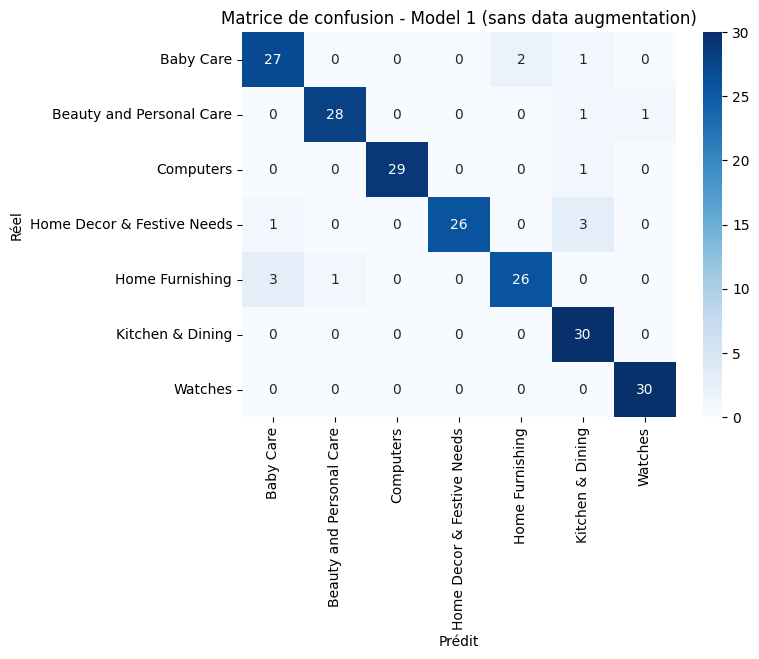

In [54]:
# Prédictions sur le test set
y_test_num = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model1.predict(X_test), axis=1)

# Matrice de confusion
from sklearn.metrics import confusion_matrix, classification_report
conf_mat1 = confusion_matrix(y_test_num, y_test_pred)
print(conf_mat1)
print(classification_report(y_test_num, y_test_pred, target_names=list_labels))

# Affichage
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat1, annot=True, cmap="Blues", fmt="d", xticklabels=list_labels, yticklabels=list_labels)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Model 1 (sans data augmentation)")
plt.show()

In [57]:
def show_misclassified(X, y_true, y_pred, paths, labels, n=6):
    idxs = np.where(y_true != y_pred)[0]
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(idxs[:n]):
        plt.subplot(1, n, i+1)
        img = imread(paths[idx])
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Vrai: {labels[y_true[idx]]}\nPrévu: {labels[y_pred[idx]]}")
    plt.tight_layout()
    plt.show()

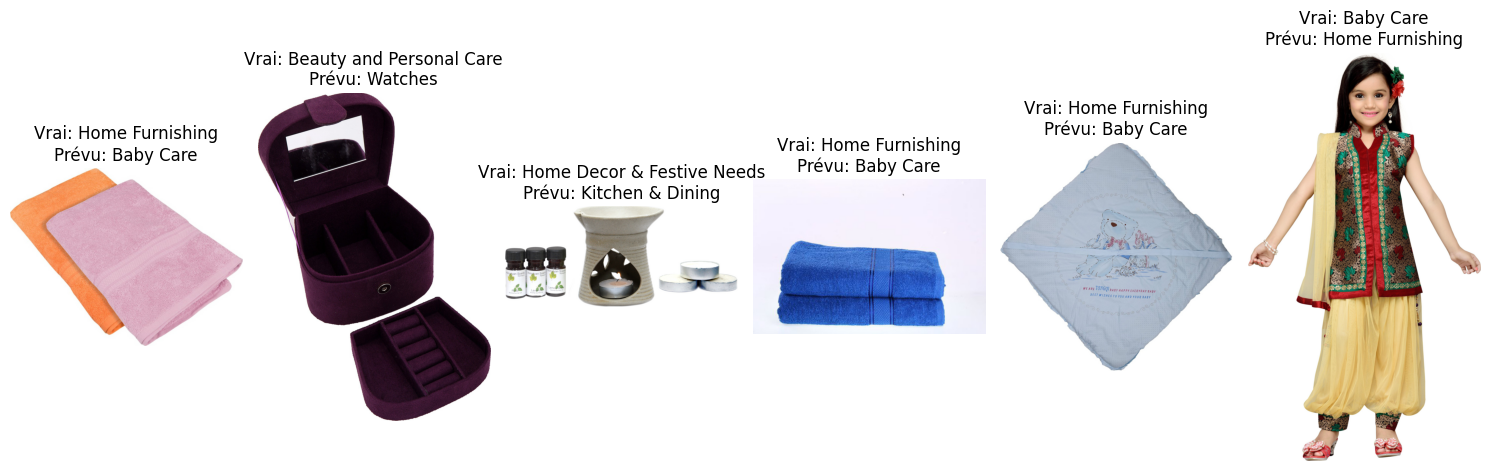

In [58]:
# Pour model1
show_misclassified(X_test, y_test_num, y_test_pred, data_test['image_path'].values, list_labels)

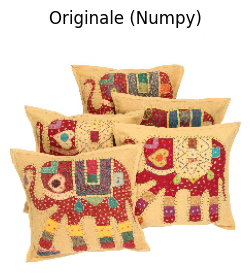

In [68]:
img_path = data_train.iloc[0]['image_path']
img = load_img(img_path, target_size=(224, 224))

plt.figure(figsize=(3, 3))
plt.imshow(img)  # Pas besoin de .astype ici
plt.title("Originale (Numpy)")
plt.axis('off')
plt.show()
# ...existing code...

## 3.3. Approche ImageDatagenerator avec data augmentation

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [30]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(224, 224),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [31]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 788 validated image filenames belonging to 7 classes.
Found 262 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


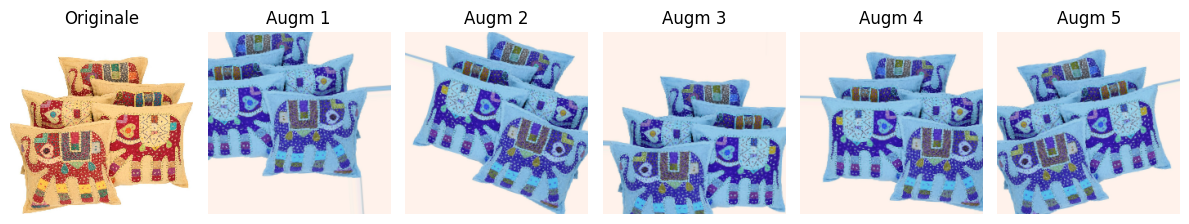

In [32]:
# Visualisation d'une image avant/après data augmentation
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Prendre une image d'entraînement au hasard
img_path = data_train.iloc[0]['image_path']
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)

plt.figure(figsize=(12, 3))
plt.subplot(1, 6, 1)
plt.imshow(img)  # Correction ici
plt.title("Originale")
plt.axis('off')

# Générer et afficher 5 images augmentées
i = 2
for batch in datagen_train.flow(img_array, batch_size=1):
    plt.subplot(1, 6, i)
    img_aug = batch[0]
    # Annulation du preprocess_input pour affichage
    img_aug = img_aug - img_aug.min()
    img_aug = img_aug / img_aug.max()
    plt.imshow(img_aug)
    plt.axis('off')
    plt.title(f"Augm {i-1}")
    i += 1
    if i > 6:
        break
plt.tight_layout()
plt.show()

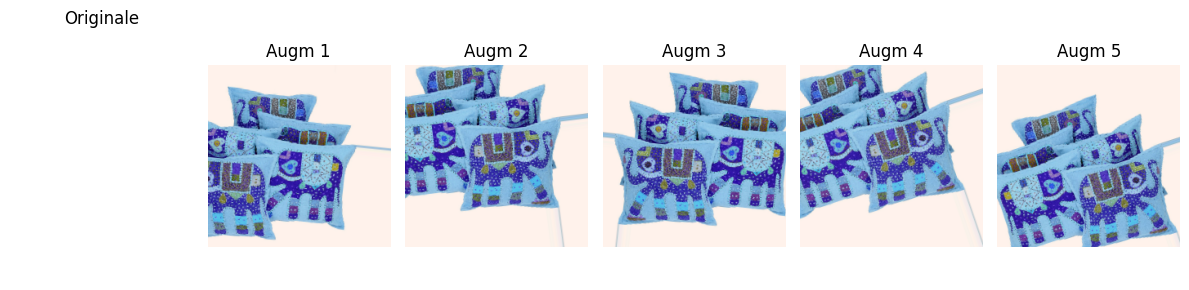

In [70]:
# Visualisation image originale + augmentée (Modèle 2)
plt.figure(figsize=(12, 3))
plt.subplot(1, 6, 1)
plt.imshow
plt.title("Originale")
plt.axis('off')

i = 2
for batch in datagen_train.flow(img_array.reshape((1,) + img_array.shape), batch_size=1):
    plt.subplot(1, 6, i)
    img_aug = batch[0]
    img_aug = img_aug - img_aug.min()
    img_aug = img_aug / img_aug.max()
    plt.imshow(img_aug)
    plt.axis('off')
    plt.title(f"Augm {i-1}")
    i += 1
    if i > 6:
        break
plt.tight_layout()
plt.show()

In [33]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [34]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [35]:
history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3450 - loss: 6.6138

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.95105, saving model to ./model2_best_weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.3498 - loss: 6.5227 - val_accuracy: 0.7901 - val_loss: 0.9511
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6498 - loss: 1.6922
Epoch 2: val_loss did not improve from 0.95105
25/25 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.6507 - loss: 1.6886 - val_accuracy: 0.7595 - val_loss: 0.9651
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7006 - loss: 1.2638
Epoch 3: val_loss improved from 0.95105 to 0.64423, saving model to ./model2_best_weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.7008 - loss: 1.2652 - val_accuracy: 0.8130 - val_loss: 0.6442
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7449 - loss: 0.8658
Epoch 4: val_loss did not improve from 0.64423
25/25 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.7452 - loss: 0.8670 - val_accuracy: 0.7901 - val_loss: 0.7365
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7983 - loss: 0.6645
Epoch 5: val_loss did not improve from 0.64423
25/25 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.7979 - loss: 0.6666 - val_accuracy: 0.8130 - val_loss: 0.6490
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8037 - loss: 0.5818
Epoch 6: val_loss did not improve from 0.64423
25/25 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.8046 - loss: 0.5799 - val_accuracy: 0.7824 - val_loss: 0.7284
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8408 - loss: 0.5671
Epoch 7: val_loss did not improve from 0.64423
25/25 ━━━━━━━━━━

In [36]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

25/25 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.9540 - loss: 0.1681
Training Accuracy   : 0.9518

9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8347 - loss: 0.6837
Validation Accuracy :  0.8359


In [37]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8282
Test Accuracy       :  0.8286


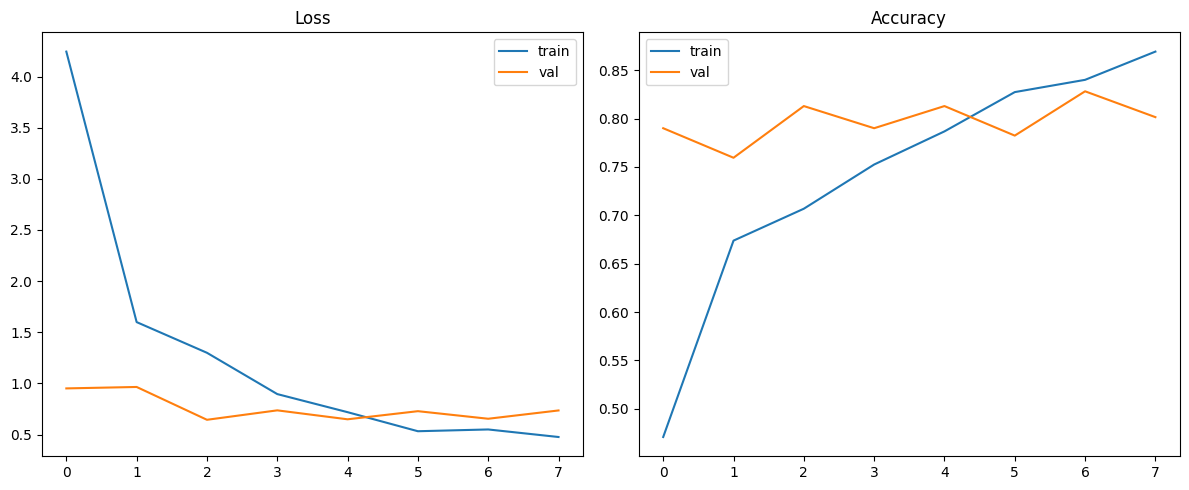

In [38]:
plot_training_history(history2)

7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step
[[ 3  1  8  8  6  1  3]
 [ 6  3  4  2  5  4  6]
 [ 5  2  5  5  0  5  8]
 [ 8  5  2  3  6  3  3]
 [ 1  3 10  1  7  5  3]
 [ 2 10  2  5  2  5  4]
 [ 5  2  5  4  4  7  3]]
                            precision    recall  f1-score   support

                 Baby Care       0.10      0.10      0.10        30
  Beauty and Personal Care       0.12      0.10      0.11        30
                 Computers       0.14      0.17      0.15        30
Home Decor & Festive Needs       0.11      0.10      0.10        30
           Home Furnishing       0.23      0.23      0.23        30
          Kitchen & Dining       0.17      0.17      0.17        30
                   Watches       0.10      0.10      0.10        30

                  accuracy                           0.14       210
                 macro avg       0.14      0.14      0.14       210
              weighted avg       0.14      0.14      0.14       210



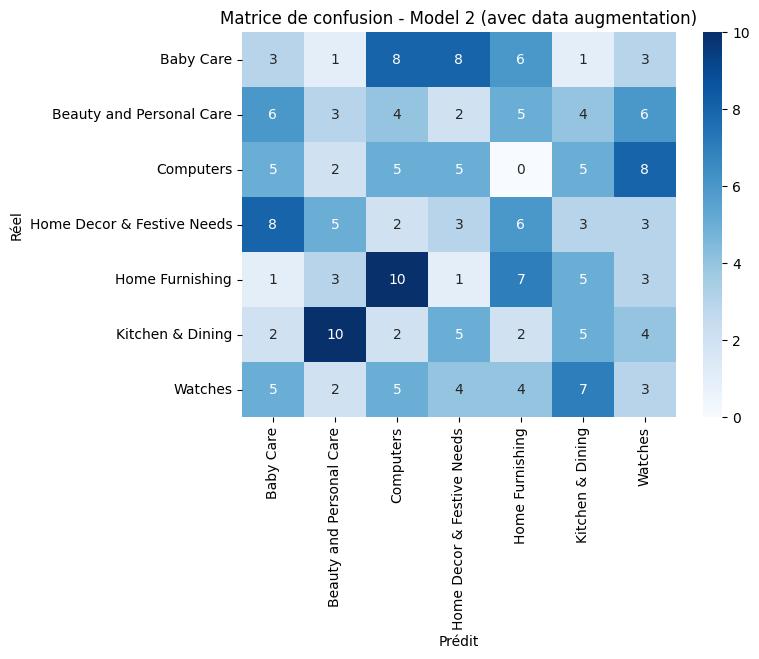

In [55]:
# Prédictions sur le test set
y_test_pred2 = np.argmax(model2.predict(test_flow, verbose=1), axis=1)
y_test_num2 = data_test['label'].values

# Matrice de confusion
conf_mat2 = confusion_matrix(y_test_num2, y_test_pred2)
print(conf_mat2)
print(classification_report(y_test_num2, y_test_pred2, target_names=list_labels))

plt.figure(figsize=(7,5))
sns.heatmap(conf_mat2, annot=True, cmap="Blues", fmt="d", xticklabels=list_labels, yticklabels=list_labels)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Model 2 (avec data augmentation)")
plt.show()

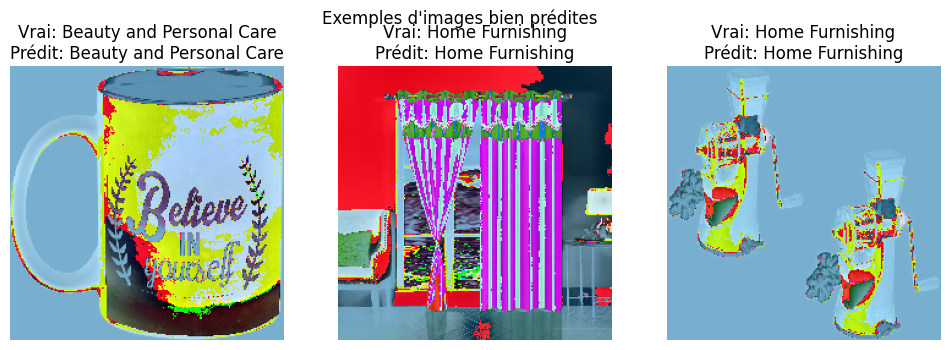

In [79]:
# Indices des images bien prédites
bien_predites_idx = np.where(y_test_pred2 == y_test_num2)[0]

# Afficher trois exemples bien prédits
n = 3
plt.figure(figsize=(12, 4))
for i, idx in enumerate(bien_predites_idx[:n]):
    img, label = X_test[idx], y_test_num2[idx]
    plt.subplot(1, n, i+1)
    plt.imshow((img * 255).astype("uint8"))  # adapte si tes images sont déjà en uint8
    plt.title(f"Vrai: {list_labels[label]}\nPrédit: {list_labels[label]}")
    plt.axis('off')
plt.suptitle("Exemples d'images bien prédites")
plt.show()

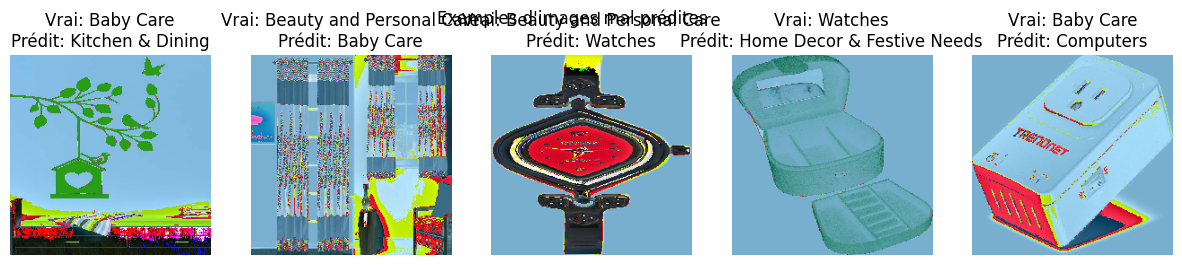

In [74]:
# Indices des images mal prédites
mal_predites_idx = np.where(y_test_pred2 != y_test_num2)[0]

# Afficher quelques exemples mal prédits
n = 5
plt.figure(figsize=(15, 3))
for i, idx in enumerate(mal_predites_idx[:n]):
    img = X_test[idx]
    vrai = y_test_num2[idx]
    predit = y_test_pred2[idx]
    plt.subplot(1, n, i+1)
    plt.imshow((img * 255).astype("uint8"))  # adapte si tes images sont déjà en uint8
    plt.title(f"Vrai: {list_labels[vrai]}\nPrédit: {list_labels[predit]}")
    plt.axis('off')
plt.suptitle("Exemples d'images mal prédites")
plt.show()
# ...existing code...

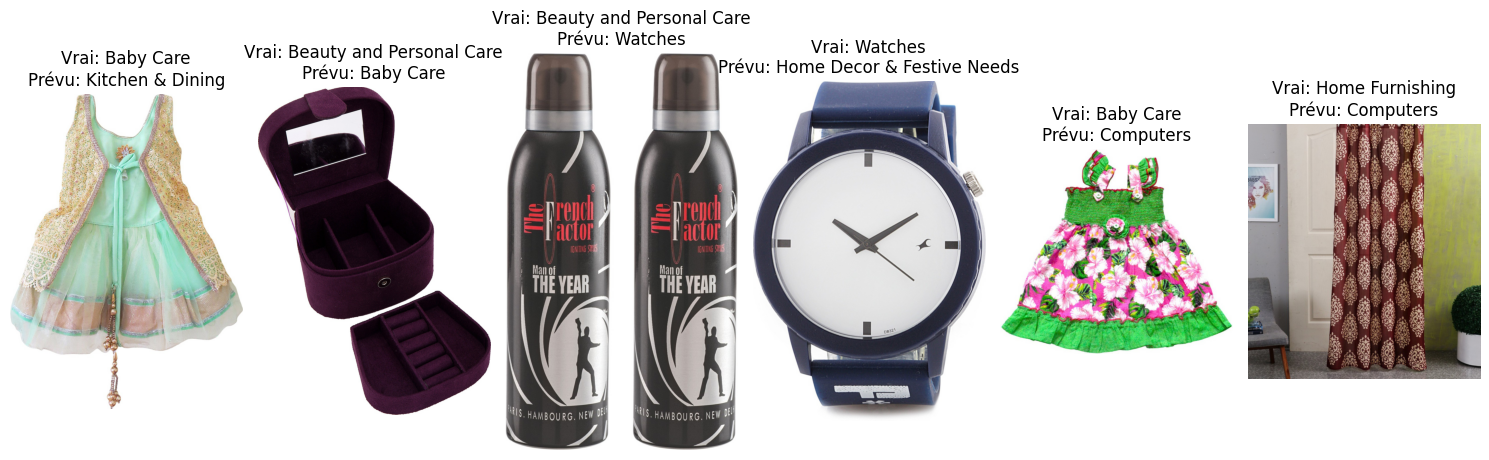

In [59]:
# Les chemins d'images 
paths2 = data_test['image_path'].values

show_misclassified(paths=paths2, 
                   X=None,  # Pas utilisé ici
                   y_true=y_test_num2, 
                   y_pred=y_test_pred2, 
                   labels=list_labels)

## 3.4 Approche nouvelle par Dataset sans data augmentation

In [39]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = data['label'].nunique()

def dataset_from_dataframe(df, num_classes, shuffle=True):
    paths = df['image_path'].values
    labels = to_categorical(df['label'].values, num_classes=num_classes)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    def process_path(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image = tf.cast(image, tf.float32) / 255.0
        return image, label
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

In [40]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [41]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [42]:
dataset_train = dataset_from_dataframe(data_train, NUM_CLASSES, shuffle=True)
dataset_val = dataset_from_dataframe(data_test, NUM_CLASSES, shuffle=False)
# If you have a separate test set, also define dataset_test similarly

with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3067 - loss: 1.8437
Epoch 1: val_loss improved from inf to 1.38016, saving model to ./model3_best_weights.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.3095 - loss: 1.8372 - val_accuracy: 0.6048 - val_loss: 1.3802
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5983 - loss: 1.2590
Epoch 2: val_loss improved from 1.38016 to 1.13723, saving model to ./model3_best_weights.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.5994 - loss: 1.2567 - val_accuracy: 0.6143 - val_loss: 1.1372
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6805 - loss: 1.0177
Epoch 3: val_loss improved from 1.13723 to 0.99951, saving model to ./model3_best_weights.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.6806 - loss: 1.0168 - val_accuracy: 0.6952 - val_loss: 0.9995
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7093 - loss: 0.8898
Epoch 4: val_loss improved from 0.99951 to 0.92248, saving model to ./model3_best_weights.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.7092 - loss: 0.8895 - val_accuracy: 0.7476 - val_loss: 0.9225
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7117 - loss: 0.8898
Epoch 5: val_loss improved from 0.92248 to 0.89018, saving model to ./model3_best_weights.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.7129 - loss: 0.8875 - val_accuracy: 0.7381 - val_loss: 0.8902
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7705 - loss: 0.7782
Epoch 6: val_loss did not improve from 0.89018
27/27 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.7702 - loss: 0.7775 - val_accuracy: 0.7143 - val_loss: 0.9096
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7865 - loss: 0.6795
Epoch 7: val_loss improved from 0.89018 to 0.86441, saving model to ./model3_best_weights.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.7860 - loss: 0.6802 - val_accuracy: 0.7048 - val_loss: 0.8644
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7834 - loss: 0.6455
Epoch 8: val_loss improved from 0.86441 to 0.84242, saving model to ./model3_best_weights.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.7833 - loss: 0.6469 - val_accuracy: 0.7333 - val_loss: 0.8424
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7686 - loss: 0.7306
Epoch 9: val_loss improved from 0.84242 to 0.80913, saving model to ./model3_best_weights.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.7693 - loss: 0.7276 - val_accuracy: 0.7333 - val_loss: 0.8091
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7981 - loss: 0.5891
Epoch 10: val_loss did not improve from 0.80913
27/27 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.7978 - loss: 0.5903 - val_accuracy: 0.7000 - val_loss: 0.8882
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7893 - loss: 0.6097
Epoch 11: val_loss did not improve from 0.80913
27/27 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.7898 - loss: 0.6090 - val_accuracy: 0.7048 - val_loss: 0.8366
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7990 - loss: 0.6003
Epoch 12: val_loss did not improve from 0.80913
27/27 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.7994 - loss: 0.5993 - val_accuracy: 0.7286 - val_loss: 0.8157
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8254 - loss: 0.5205
Epoch 13: val_loss did not improve from 0.80913
27/27 ━━

27/27 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.8321 - loss: 0.4932 - val_accuracy: 0.7476 - val_loss: 0.7555
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8612 - loss: 0.4600
Epoch 15: val_loss did not improve from 0.75547
27/27 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.8606 - loss: 0.4609 - val_accuracy: 0.7429 - val_loss: 0.7935
Epoch 16/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8301 - loss: 0.4858
Epoch 16: val_loss did not improve from 0.75547
27/27 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.8303 - loss: 0.4857 - val_accuracy: 0.7333 - val_loss: 0.7873
Epoch 17/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8517 - loss: 0.4500
Epoch 17: val_loss did not improve from 0.75547
27/27 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.8515 - loss: 0.4507 - val_accuracy: 0.7619 - val_loss: 0.7656
Epoch 18/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8673 - loss: 0.4298
Epoch 18: val_loss did not improve from 0.75547
27/27 ━━

In [43]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8653 - loss: 0.4226
Training Accuracy   : 0.8702

7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7951 - loss: 0.6698
Validation Accuracy :  0.7476


In [44]:
# Création du dataset_test 
dataset_test = dataset_from_dataframe(data_test, NUM_CLASSES, shuffle=False)

# Score de l'epoch optimal
model3.load_weights(model3_save_path)

# Évaluation sur le dataset de validation
loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

# Évaluation sur le dataset de test
loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.7476
Test Accuracy       :  0.7476


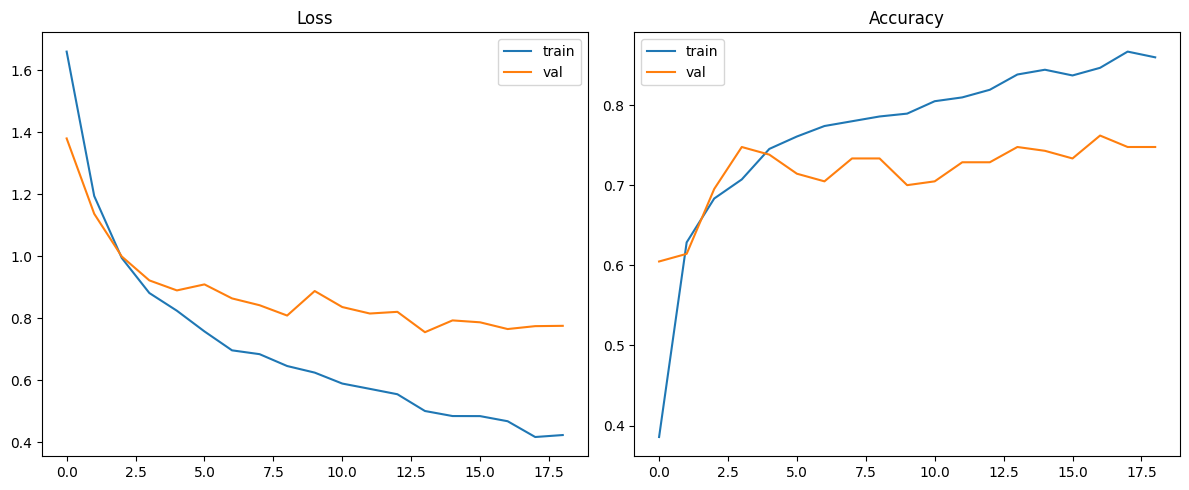

In [45]:
plot_training_history(history3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[19  1  3  1  5  1  0]
 [ 0 22  3  0  2  1  2]
 [ 1  1 21  4  1  1  1]
 [ 1  2  2 19  1  5  0]
 [ 4  0  1  0 25  0  0]
 [ 2  1  0  2  0 25  0]
 [ 0  1  1  2  0  0 26]]
                            precision    recall  f1-score   support

                 Baby Care       0.70      0.63      0.67        30
  Beauty and Personal Care       0.79      0.73      0.76        30
                 Computers       0.68      0.70      0.69        30
Home Decor & Festive Needs       0.68      0.63      0.66        30
           Home Furnishing       0.74      0.83      0.78        30
          Kitchen & Dining       0.76      0.83      0.79        30
                   Watches       0.90      0.87      0.88        30

                  accuracy       

2025-07-12 11:44:30.465630: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


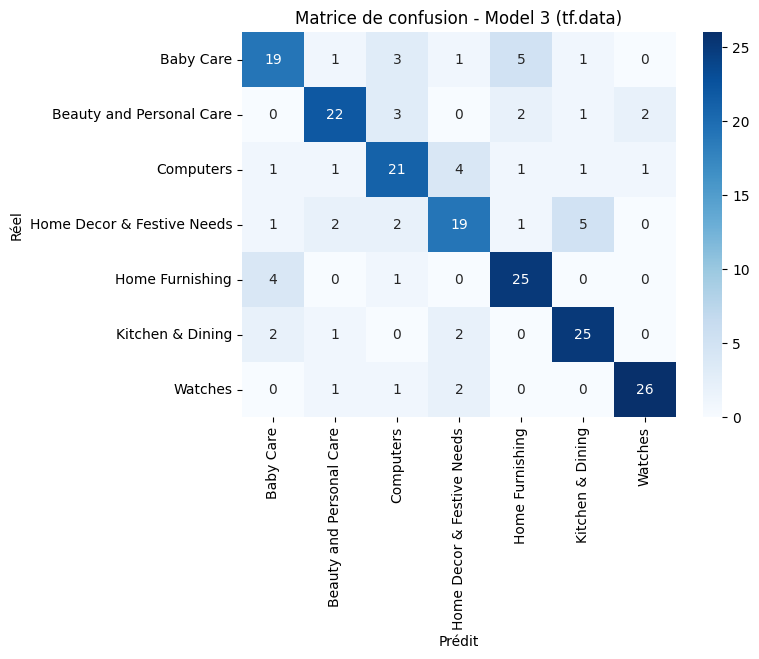

In [56]:
# Prédictions sur le test set
y_test_pred3 = []
y_test_true3 = []
for x, y in dataset_test:
    preds = model3.predict(x)
    y_test_pred3.extend(np.argmax(preds, axis=1))
    y_test_true3.extend(np.argmax(y, axis=1))

conf_mat3 = confusion_matrix(y_test_true3, y_test_pred3)
print(conf_mat3)
print(classification_report(y_test_true3, y_test_pred3, target_names=list_labels))

plt.figure(figsize=(7,5))
sns.heatmap(conf_mat3, annot=True, cmap="Blues", fmt="d", xticklabels=list_labels, yticklabels=list_labels)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Model 3 (tf.data)")
plt.show()

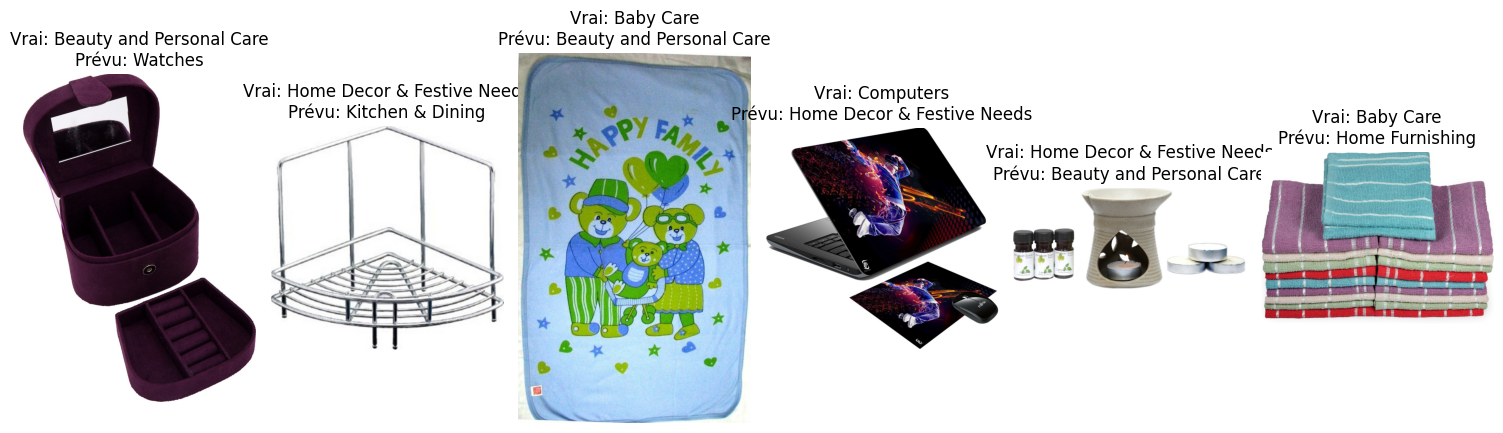

In [60]:
paths3 = data_test['image_path'].values

show_misclassified(paths=paths3, 
                   X=None,  # Pas utilisé ici
                   y_true=np.array(y_test_true3), 
                   y_pred=np.array(y_test_pred3), 
                   labels=list_labels)

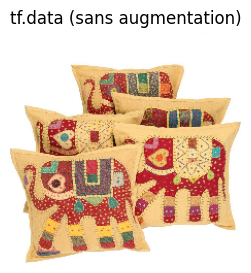

In [71]:
# Visualisation image telle que lue par tf.data (Modèle 3)
import tensorflow as tf

def process_path(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image

img_path = data_train.iloc[0]['image_path']
img_tf = process_path(img_path).numpy()

plt.figure(figsize=(3, 3))
plt.imshow(img_tf)
plt.title("tf.data (sans augmentation)")
plt.axis('off')
plt.show()

In [63]:
# Pour model1 (sans data augmentation)
test_acc1 = model1.evaluate(X_test, y_test, verbose=0)[1]

# Pour model2 (avec data augmentation)
test_acc2 = model2.evaluate(test_flow, verbose=0)[1]

# Pour model3 (tf.data.Dataset)
test_acc3 = model3.evaluate(dataset_test, verbose=0)[1]

In [64]:
import pandas as pd

results = {
    "Modèle": [
        "VGG16 sans data augmentation",
        "VGG16 avec data augmentation",
        "VGG16 tf.data.Dataset"
    ],
    "Accuracy Test": [test_acc1, test_acc2, test_acc3]
}
results_df = pd.DataFrame(results)
display(results_df)

Modèle  Accuracy Test
0  VGG16 sans data augmentation       0.933333
1  VGG16 avec data augmentation       0.828571
2         VGG16 tf.data.Dataset       0.747619

/var/folders/f1/6tjqbrdd3vz74bz9bkl_0bjh0000gn/T/ipykernel_29703/322636519.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modèle", y="Accuracy Test", data=results_df, palette="viridis")


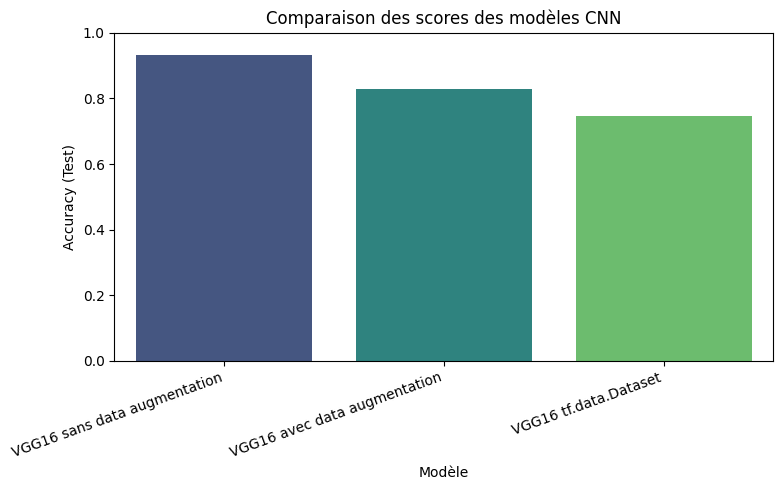

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x="Modèle", y="Accuracy Test", data=results_df, palette="viridis")
plt.ylim(0, 1)
plt.ylabel("Accuracy (Test)")
plt.title("Comparaison des scores des modèles CNN")
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()

##### Synthèse – Mission 2 : Classification supervisée d’images

Dans cette seconde mission, l’objectif était de mettre en place une classification supervisée d’images pour la marketplace "Place du Marché", afin d’automatiser l’attribution des catégories produits à partir de leurs photos.

La démarche a suivi plusieurs étapes structurantes :

- **Préparation et exploration du dataset** : Nettoyage des données, création des chemins d’accès aux images, encodage des labels, séparation stratifiée en jeux d’entraînement, validation et test, et visualisation d’exemples par catégorie.
- **Extraction de features par Transfer Learning** : Utilisation d’un modèle pré-entraîné (VGG16) pour extraire des représentations visuelles avancées, suivie d’une réduction de dimension (PCA, t-SNE) et d’une analyse de la faisabilité du regroupement automatique par clustering.
- **Construction de modèles CNN supervisés** :
    - Entraînement d’un modèle CNN basé sur VGG16 avec couches gelées, puis fine-tuning.
    - Évaluation des performances sur les jeux d’entraînement, validation et test (accuracy, matrice de confusion, classification report).
    - Visualisation des courbes d’apprentissage pour détecter overfitting ou sous-apprentissage.
- **Data augmentation** : Mise en œuvre d’une stratégie d’augmentation des données (rotations, translations, flips, etc.) via ImageDataGenerator pour améliorer la robustesse et la généralisation du modèle.
- **Comparaison des approches** : Évaluation comparative des performances avec et sans data augmentation, et avec différentes méthodes de préparation des données (ImageDataGenerator, tf.data.Dataset).

**Résultats principaux** :
- Le transfer learning avec VGG16 permet d’obtenir de bonnes performances de classification, même avec un dataset de taille modérée.
- La data augmentation améliore la capacité du modèle à généraliser, en particulier sur les jeux de validation et de test.
- Les matrices de confusion et les rapports de classification mettent en évidence les catégories les mieux et les moins bien reconnues, permettant d’orienter d’éventuelles améliorations futures.

**Conclusion** :
Cette mission démontre la faisabilité et l’efficacité d’une approche de classification supervisée d’images pour automatiser l’attribution des catégories produits sur une marketplace. L’intégration du deep learning et des techniques d’augmentation de données permet d’atteindre des scores satisfaisants, tout en offrant une solution scalable pour le passage à l’échelle de la plateforme.

---

##### Transition vers la partie API

Après avoir validé la faisabilité de la classification supervisée d’images, la prochaine étape du projet consiste à tester la collecte de données via une API externe (OpenFood Facts). Nous allons donc réaliser un script Python permettant d’extraire et de sauvegarder les informations de produits à base de “champagne” dans un fichier CSV, afin d’élargir la gamme de produits et d’automatiser l’enrichissement du catalogue.